## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from ftfy import fix_text
from num2words import num2words

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import sklearn

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the data and check the first few lines
dataset_path = "../Raw Data Files/fake_job_postings.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 2. Basic Understanding of the Data

In [3]:
print(dataset.shape)
dataset.info()

(17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

In [4]:
dataset.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<Axes: >

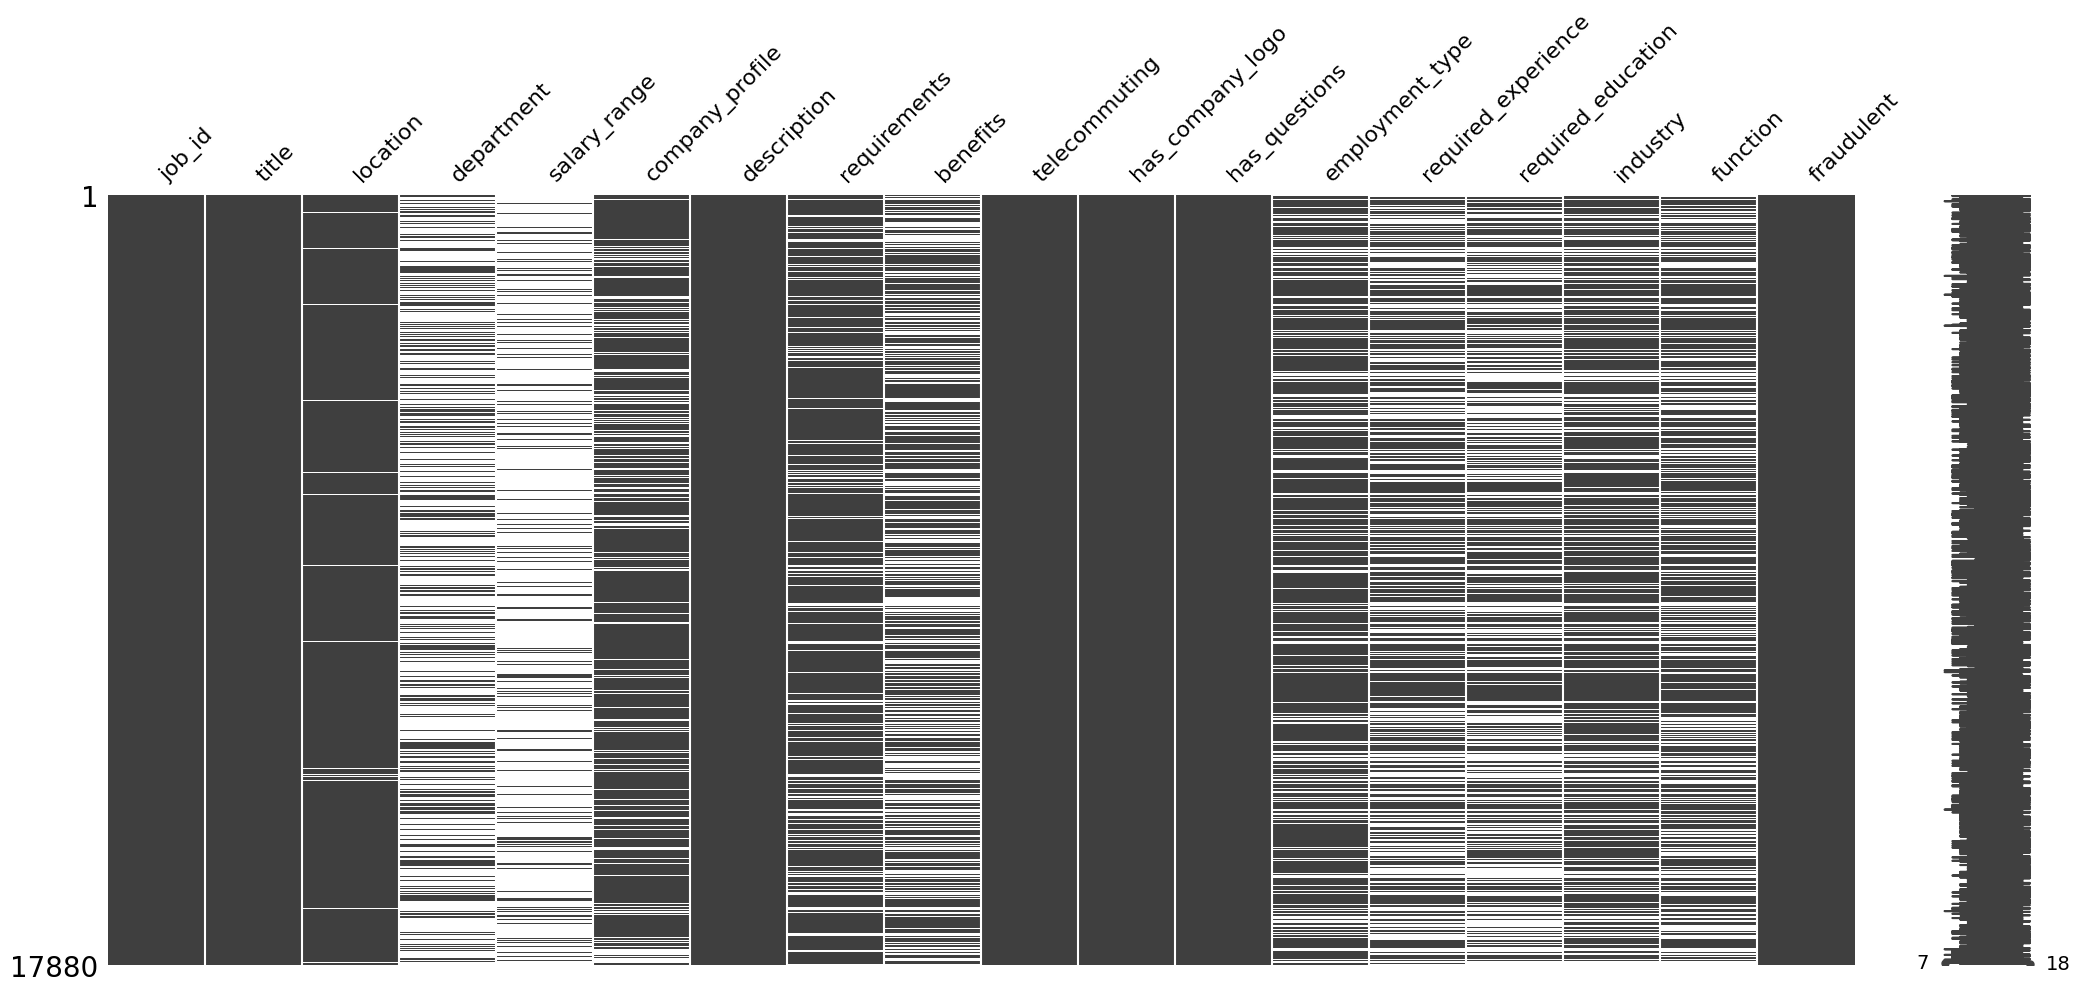

In [5]:
# Alternative way to have a quick glance to check missing values
missingno.matrix(dataset)

From the data, we understand that there are 0 duplicated rows and there are a lot of data columns that has a lot of NA values especially department and salary range. This is followed by required_education, benefits and required_experience. We will dive deep to understand each data columns better to make a decision if we want to drop the column or not.

## 2. Feature Engineering

### 2.1 Salary Range > Salary Group

In [6]:
#### one way to deal with salary_range: treat as numerical feature, fill in with 0
# Function to process salary_range
def process_salary_range(salary_range):
    if '-' in str(salary_range):
        start, end = salary_range.split('-')
    else:
        start = salary_range
        end = salary_range
    return start, end

dataset[['salary_start', 'salary_end']] = dataset['salary_range'].apply(process_salary_range).apply(pd.Series)

# clean salary_range with wrong format
mon_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dataset.loc[dataset['salary_start'].isin(mon_list),'salary_start'] = 0
dataset.loc[dataset['salary_start'].isin(mon_list),'salary_end'] = 0
dataset.loc[dataset['salary_end'].isin(mon_list),'salary_start'] = 0
dataset.loc[dataset['salary_end'].isin(mon_list),'salary_end'] = 0

# fill in with 0
dataset[['salary_start', 'salary_end']] = dataset[['salary_start', 'salary_end']].fillna(0)
dataset[['salary_start', 'salary_end']] = dataset[['salary_start', 'salary_end']].astype(int)
dataset['salary_interval'] = dataset['salary_end'] - dataset['salary_start']

In [7]:
#### another way: binary feature - 1 when has normal salary_range, 0 when doesn't


In [8]:
# salary_group: bin then fill in with most common
# salary_range: fill in with 'unspecified' and use frequency encoding

dataset['salary_group'] = dataset['salary_range']
for idx in (dataset['salary_group'].dropna()).index:
    Range = dataset.at[idx ,'salary_group'].split('-')
    try :
        starts = int(Range[0])
        if len(Range)==2:
          ends = int(Range[1])
        else:
          ends = starts
        salary = (starts + ends)/2
        if salary <= 1000:
          dataset.at[idx ,'salary_group'] = 'extremely low'
        elif salary > 1000 and salary <= 30000:
          dataset.at[idx ,'salary_group'] = 'low'
        elif salary > 30000 and salary <= 100000:
          dataset.at[idx ,'salary_group'] = 'slightly low'
        elif salary > 100000 and salary <= 500000:
          dataset.at[idx ,'salary_group'] = 'slightly high'
        elif salary > 500000 and salary <= 1000000:
          dataset.at[idx ,'salary_group'] = 'high'
        elif salary > 1000000:
          dataset.at[idx ,'salary_group'] = 'extremely high'
    except ValueError:
        dataset.at[idx ,'salary_group'] = np.NaN

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_start,salary_end,salary_interval,salary_group
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,0,0,0,NaN
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0,0,0,NaN
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0,0,0,NaN
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0,0,0,NaN


In [9]:
# salary_group
dataset.salary_group.value_counts(dropna=False).head(5)

salary_group
NaN              15038
slightly low      1482
low                644
extremely low      346
slightly high      319
Name: count, dtype: int64

### 2.2 Split Location

In [10]:
# split location, only keep country
dataset['location_country'] = dataset['location'].str.split(',').str[0].str.strip()
#dataset['location_county'] = dataset['location'].str.split(',').str[1].str.strip()
#dataset['location_city'] = dataset['location'].str.split(',').str[2].str.strip()
#columns = ['location_country','location_county','location_city']
columns = ['location_country']
dataset[columns] = dataset[columns].applymap(lambda x: x if x else np.NaN)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_start,salary_end,salary_interval,salary_group,location_country
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,0,0,0,NaN,US
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0,0,0,NaN,NZ
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,US
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0,0,0,NaN,US
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0,0,0,NaN,US


In [11]:
# location_country
dataset['location_country'].value_counts(dropna=False).head(10)

location_country
US     10656
GB      2384
GR       940
CA       457
DE       383
NaN      346
NZ       333
IN       276
AU       214
PH       132
Name: count, dtype: int64

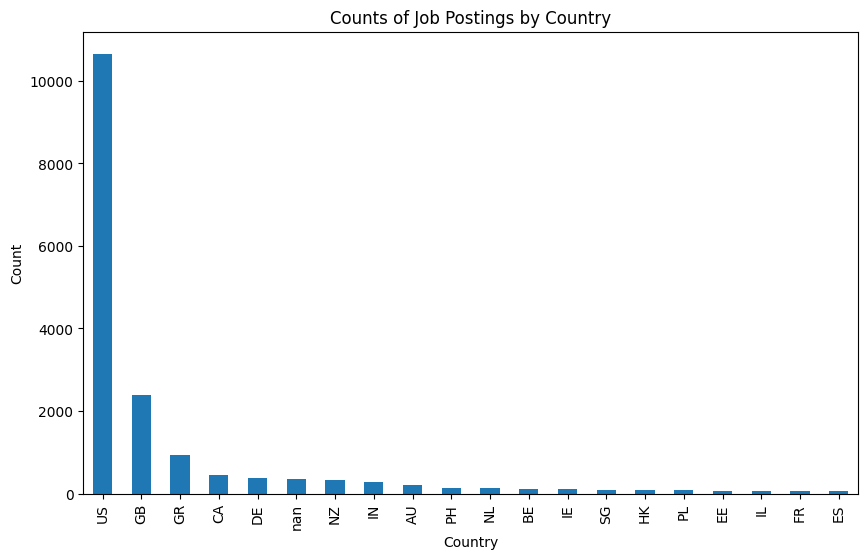

In [12]:
all_ctry = dataset['location_country'].value_counts(dropna=False)

top_20 = dataset['location_country'].value_counts(dropna=False).head(20)

plt.figure(figsize=(10, 6))
top_20.plot(kind='bar')
plt.title('Counts of Job Postings by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [13]:
# location_county
# dataset['location_county'].value_counts(dropna=False).head(10)

In [14]:
# location_city
# dataset['location_city'].value_counts(dropna=False).head(10)

### 2.3 Title, Company Profile, Description, Requirements, Benefits

In [15]:
dataset['title_contain_urgent'] = dataset['title'].apply(lambda x: 1 if 'urgent' in x.lower() else 0)
dataset['have_company_profile'] = np.where(dataset['company_profile'].notnull(), 1, 0)
dataset['have_description'] = np.where(dataset['description'].notnull(), 1, 0)
dataset['have_requirements'] = np.where(dataset['requirements'].notnull(), 1, 0)
dataset['have_benefits'] = np.where(dataset['benefits'].notnull(), 1, 0)

# combine text, add in 'title'
dataset[['company_profile']] = dataset[['company_profile']].fillna('')
dataset[['description']] = dataset[['description']].fillna('')
dataset[['requirements']] = dataset[['requirements']].fillna('')
dataset[['benefits']] = dataset[['benefits']].fillna('')
dataset['full_text'] = dataset['title'] + ' ' + dataset['company_profile'] + ' ' + dataset['description'] + ' ' + dataset['requirements'] + ' ' + dataset['benefits']

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_start,salary_end,salary_interval,salary_group,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,0,0,0,NaN,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0,0,0,NaN,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0,0,0,NaN,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0,0,0,NaN,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...


## 3. Data Cleaning

In [16]:
# drop useless columns
drop_cols = ['job_id','location','company_profile','description','requirements','benefits']
dataset = dataset.drop(drop_cols,axis=1)
dataset.head()

,title,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_start,salary_end,salary_interval,salary_group,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text
0,Marketing Intern,Marketing,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,0,0,0,NaN,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat..."
1,Customer Service - Cloud Video Production,Success,NaN,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0,0,0,NaN,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...
2,Commissioning Machinery Assistant (CMA),NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...
3,Account Executive - Washington DC,Sales,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0,0,0,NaN,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...
4,Bill Review Manager,NaN,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0,0,0,NaN,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...


### 3.1 Handle Missing Values

Columns with Missing Values:
- salary_range           15012
- location                 346
- company_profile         3308
description                1
requirements            2695
benefits                7210
- industry                4903
department             11547
function                6455
- employment_type         3471
required_experience     7050
required_education      8105

#### 3.1.1 location

In [17]:
dataset['location_country'] = dataset['location_country'].fillna('unspecified')

#### 3.1.2 salary_range & salary_group

In [18]:
## salary_range: refer to the above part
## salary_group: 'unspecified'?

## high_salary is a binary indicator if the salary is in high or extremely high range
dataset['high_salary']=dataset['salary_group'].isin(['high'])

#### 3.1.3 department & industry & function

In [19]:
# fill in with the help of key words from 'title'
str_list = ['Engineer','Account','Accountant','Accounting','Developer','Sales','Marketing','Beauty','Service','Customer','Consumer',
'Customer','Writer','Pet','Architect', 'Dog', 'Game', 'Mobile', 'Design', 'Financial','Programmer']

for strs in str_list:
  dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['department'].isna()),'department'] = \
  dataset[dataset['title'].str.contains(strs, case=False, na=False)]['department'].mode()[0]
  dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['industry'].isna()),'industry'] = \
  dataset[dataset['title'].str.contains(strs, case=False, na=False)]['industry'].mode()[0]
  dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['function'].isna()),'function'] = \
  dataset[dataset['title'].str.contains(strs, case=False, na=False)]['function'].mode()[0]

dataset[['department','industry','function']] = dataset[['department','industry','function']].fillna('unspecified')

# dataset['depa_indus_func'] = dataset['department'] + ' ' + dataset['industry'] + ' ' + dataset['function']
# then clean, drop extra words

In [20]:
dataset[['department']] = dataset[['department']].fillna('')
dataset[['industry']] = dataset[['industry']].fillna('')
dataset[['function']] = dataset[['function']].fillna('')
dataset['category'] = dataset['department'] + ' ' + dataset['industry'] + ' ' + dataset['function']

#merge already and discard duplicated words
def remove_duplicates(text):
    words = text.split()
    unique_words = list(dict.fromkeys(words))
    return " ".join(unique_words)

dataset['category'] = dataset['category'].apply(remove_duplicates)

dataset.head()

,title,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_start,salary_end,salary_interval,salary_group,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,high_salary,category
0,Marketing Intern,Marketing,NaN,0,1,0,Other,Internship,NaN,Marketing and Advertising,Marketing,0,0,0,0,NaN,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",False,Marketing and Advertising
1,Customer Service - Cloud Video Production,Success,NaN,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0,0,0,NaN,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,False,Success Marketing and Advertising Customer Ser...
2,Commissioning Machinery Assistant (CMA),unspecified,NaN,0,1,0,NaN,NaN,NaN,unspecified,unspecified,0,0,0,0,NaN,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,False,unspecified
3,Account Executive - Washington DC,Sales,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0,0,0,NaN,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,False,Sales Computer Software
4,Bill Review Manager,unspecified,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0,0,0,NaN,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,False,unspecified Hospital & Health Care Provider


In [21]:
# full_text
fraud_cat = dataset[dataset.fraudulent == 1].category
nonfraud_cat = dataset[dataset.fraudulent == 0].category

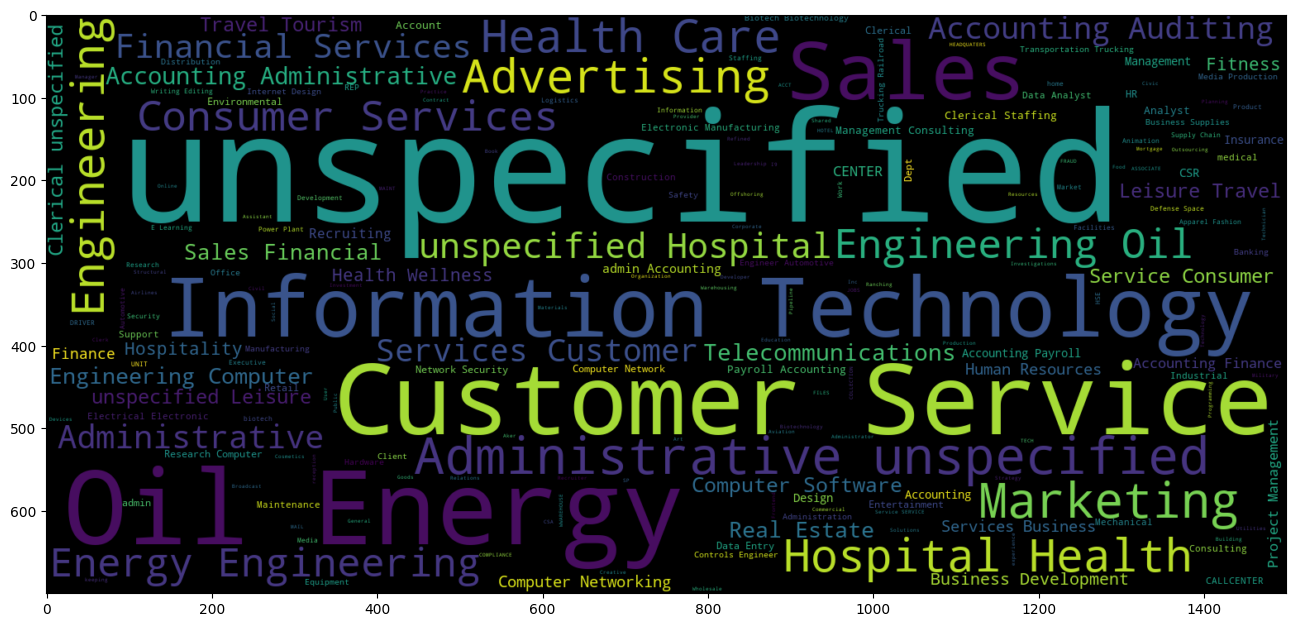

In [22]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(fraud_cat)))
plt.imshow(wc,interpolation = 'bilinear')

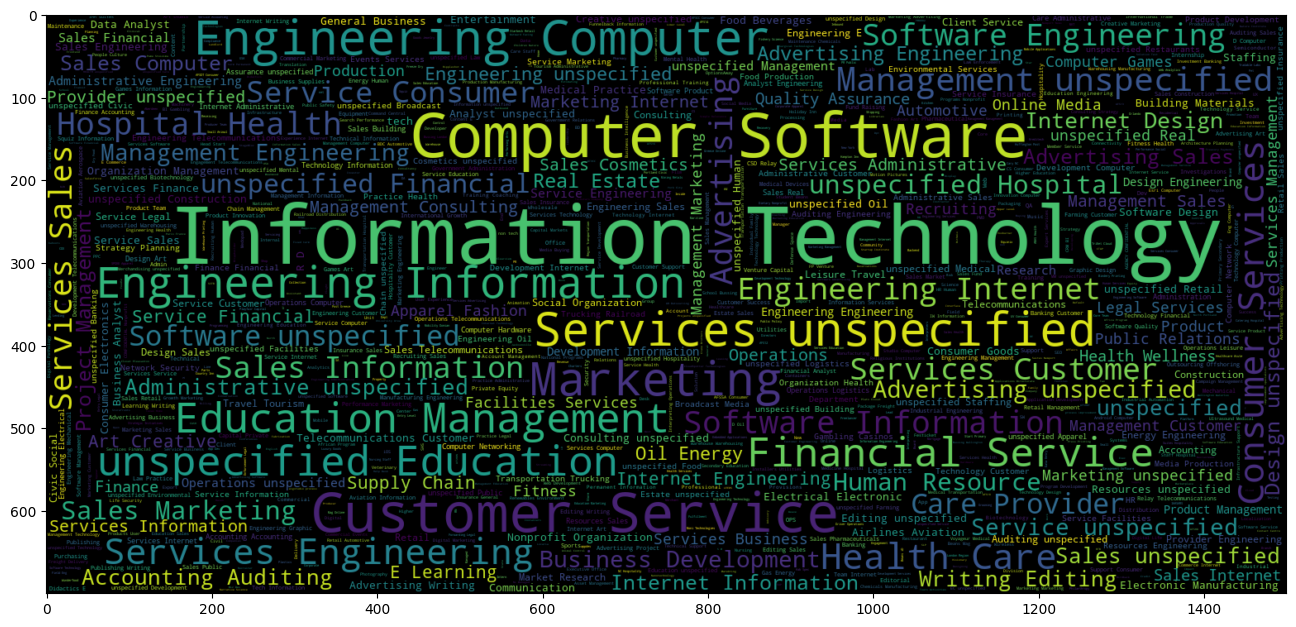

In [23]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(nonfraud_cat)))
plt.imshow(wc,interpolation = 'bilinear')

In [24]:
#textstat - check text complexity (python package) https://pypi.org/project/textstat/

import textstat

# Calculate readability scores for the "category" column
dataset['cat_flesch_score'] = dataset['category'].apply(textstat.flesch_reading_ease) #low score = very confusing
dataset['cat_fk_grade_level'] = dataset['category'].apply(textstat.flesch_kincaid_grade)

dataset.head()

,title,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_start,salary_end,salary_interval,salary_group,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,high_salary,category,cat_flesch_score,cat_fk_grade_level
0,Marketing Intern,Marketing,NaN,0,1,0,Other,Internship,NaN,Marketing and Advertising,Marketing,0,0,0,0,NaN,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",False,Marketing and Advertising,-24.64,17.4
1,Customer Service - Cloud Video Production,Success,NaN,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0,0,0,NaN,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,False,Success Marketing and Advertising Customer Ser...,6.17,13.9
2,Commissioning Machinery Assistant (CMA),unspecified,NaN,0,1,0,NaN,NaN,NaN,unspecified,unspecified,0,0,0,0,NaN,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,False,unspecified,-132.59,32.0
3,Account Executive - Washington DC,Sales,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0,0,0,NaN,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,False,Sales Computer Software,34.59,9.2
4,Bill Review Manager,unspecified,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0,0,0,NaN,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,False,unspecified Hospital & Health Care Provider,32.56,10.0


#### 3.1.4 Employment_type, Required_experience, Required_education

In [25]:
## first fill in employment_type using 'title', but if has no key words, fill in with 'unspecified'
dataset['employment_type'] = dataset['employment_type'].fillna()

## then, fill in experience & education with the mode in each sub-group of employment_type
# Other, Full-time, unspecified, Part-time, Contract, Temporary
employ_type_list = ['Full-time','Other','Part-time','Contract','Temporary','unspecified']
for employ_type in employ_type_list:
    dataset.loc[(dataset['employment_type']==employ_type) & (dataset['required_experience'].isna()),'required_experience'] = dataset[dataset['employment_type']==employ_type]['required_experience'].mode()[0]
    dataset.loc[(dataset['employment_type']==employ_type) & (dataset['required_education'].isna()),'required_education'] = dataset[dataset['employment_type']==employ_type]['required_education'].mode()[0]

ValueError: Must specify a fill 'value' or 'method'.

In [26]:
dataset.isna().sum()

title                       0
department                  0
salary_range            15012
telecommuting               0
has_company_logo            0
has_questions               0
employment_type          3471
required_experience      7050
required_education       8105
industry                    0
function                    0
fraudulent                  0
salary_start                0
salary_end                  0
salary_interval             0
salary_group            15038
location_country            0
title_contain_urgent        0
have_company_profile        0
have_description            0
have_requirements           0
have_benefits               0
full_text                   0
high_salary                 0
category                    0
cat_flesch_score            0
cat_fk_grade_level          0
dtype: int64

### 3.2 Drop Columns with Low Variance

In [27]:
# Filter numeric columns only
numeric_columns = dataset.select_dtypes(include="number")

# Calculate the variance for numeric columns
variance_info = numeric_columns.var()

# Display the variance for each numeric column
print(variance_info)

telecommuting           4.105923e-02
has_company_logo        1.628058e-01
has_questions           2.499455e-01
fraudulent              4.609073e-02
salary_start            4.977911e+13
salary_end              1.163792e+14
salary_interval         1.402458e+13
title_contain_urgent    3.066772e-03
have_company_profile    1.507905e-01
have_description        5.592841e-05
have_requirements       1.280546e-01
have_benefits           2.406733e-01
cat_flesch_score        3.270825e+03
cat_fk_grade_level      6.109801e+01
dtype: float64


In [28]:
del dataset['have_description']

### 3.3 Clean text data

In [29]:
def remove_stop_words(doc):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  docs = list(set(doc.split(' ')) - stop_words)
  return docs

def simple_stemmer(doc):
  stemmer= PorterStemmer()
  doc = ' '.join([stemmer.stem(word) for word in doc.split(' ')])
  return doc

# to clean data
def normalise_text(text,remove_stop_words=True):
    text = fix_text(text)
    text = text.lower() # lowercase
    text = text.replace("'","").replace("’","") # remove apostrophes ("can't">"cant")
    text = re.sub('#\S+#', " ", text) # removes #URL_...# #PHONE_...# #EMAIL_...# #*_...#
    text = re.sub('\xa0', " ", text) # remove \xa0
    text = re.sub('<.*?>'," ",text) # remove <> tags
    text = re.sub('#\S+', " ", text) # replaces hashtags
    text = re.sub('@\S+', " ", text)  # remove mentions
    text = re.sub("http\S+", " ", text) # remove URL addresses starting with http
    text = re.sub('www\S+', " ", text) # remove URL addresses starting with www
    text = re.sub('\d+', lambda x: ' '+num2words(x.group(), to='cardinal')+' ', text) # convert numbers to words ('food52'>'food fifty-two ')
    text = re.sub("[^a-zA-Z]", " ", text) # letters only
    text = re.sub('\s{2,}', " ", text).strip() # replace more than or equal to two white spaces into one white space
    if remove_stop_words:
      stop_words = set(nltk.corpus.stopwords.words('english'))
      text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    # if stem_words:
    # stemmer = PorterStemmer()
    # text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

In [31]:
text_cols = ['title', 'industry', 'department', 'function', 'employment_type', 'required_experience', 'required_education']
for col in text_cols:
    dataset[col] = dataset[col].apply(lambda x: normalise_text(x,remove_stop_words=False))
dataset.head()

TypeError: object of type 'float' has no len()

In [32]:
dataset['full_text'] = dataset['full_text'].apply(lambda x: normalise_text(x))
dataset['text_len'] = dataset['full_text'].apply(lambda x: len(x.split(' ')))
dataset.head()

KeyboardInterrupt: 

### 3.4 Location Values

In [33]:
# might not need
#loc_cols = ['location_country','location_county','location_city']
#for col in loc_cols:
    #dataset[col] = dataset[col].apply(lambda x: normalise_text(x,remove_stop_words=False))

## 4. Preprocessing

- frequency encoding: title,industry,department,function,salary_range
- embeddings: full_text(company_profile,description,requirements,benefits)
- one-hot encoding: others
- location: split(',') then frequency encoding

In [34]:
df = dataset.copy()

In [37]:
# train test split
from sklearn.model_selection import train_test_split
X = df.drop('fraudulent',axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023,stratify=y)

### 4.1 Encoding

In [38]:
# ordinal encoding for salary_group

from sklearn.preprocessing import OrdinalEncoder

ordinal = OrdinalEncoder(
    categories = [['Extremly Low','Low','Sligtly Low','Slightly High','High','Extremly High' ]],  # order of the categorical values
    handle_unknown = 'use_encoded_value',  #  what to do for unknown values not in the categories list
    unknown_value = -1 # what to replace these unknown values with
)

ordinal.fit_transform(X_train[['salary_group']])

array([[-1.],
       [-1.],
       [-1.],
       ...,
       [-1.],
       [-1.],
       [-1.]])

In [39]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(
    categories = [
            ['Full-time', 'Contract', 'Part-time','Temporary','Other','unavailable'], # employment_type
            ['unavailable', 'Mid-Senior level', 'Entry level', 'Associate', 'Not Applicable', 'Director', 'Internship', 'Executive'], # required_experience
            ['unavailable',"Bachelor's Degree",'High School or equivalent','Unspecified',"Master's Degree",'Associate Degree','Certification','Some College Coursework Completed','Vocational','Professional','Doctorate','Some High School Coursework','Vocational - Degree','Vocational - HS Diploma','Vocational - Other','None','Vocational - HS Certificate','Vocational - Bachelor','Vocational - Master'], # required_education
            ['Information Technology and Services', 'Computer Software','Internet','Marketing and Advertising','Education Management','Financial Services','Hospital & Health Care','Consumer Services','Telecommunications','Oil & Energy','Retail','Real Estate','Accounting','Construction'], # Industry
            ['unavailable','Information Technology','Sales','Engineering','Customer Service','Marketing','Administrative','Design','Health Care Provider','Other','Education','Management','Business Development','Accounting/Auditing','Human Resources','Project Management','Finance','Consulting','Writing/Editing','Art/Creative','Production','Quality Assurance','Data Analyst','Research','Manufacturing','Advertising','Public Relations','Legal','Distribution','Product Management','Strategy/Planning','Purchasing','General Business','Science','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Information Technology','Facilities','QA','Skilled Labor','Business Development','Research Development','Science','Professional Services','Design','Product Management','Strategy/Planning','Purchasing','General Business','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Facilities','QA','Skilled Labor','Research Development','Professional Services','Logistics','Nonprofit','Operations Management','Nurse','Pharmaceutical'], # function
            ['US','GB','GR','CA','DE'] # location_country
     ],
     handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

onehot.fit_transform(X_train[[ 'employment_type', 'required_experience','required_education','industry','function','location_country']])

<12516x119 sparse matrix of type '<class 'numpy.float64'>'
	with 34786 stored elements in Compressed Sparse Row format>

In [40]:
pd.DataFrame.sparse.from_spmatrix(
    data = onehot.fit_transform(X_train[['employment_type', 'required_experience','required_education','industry','function','location_country']]),  # <- sparse matrix
    columns = onehot.get_feature_names_out(),                        # <- encoded features
    index = X_train.index
)

,employment_type_Full-time,employment_type_Contract,employment_type_Part-time,employment_type_Temporary,employment_type_Other,employment_type_unavailable,required_experience_unavailable,required_experience_Mid-Senior level,required_experience_Entry level,required_experience_Associate,required_experience_Not Applicable,required_experience_Director,required_experience_Internship,required_experience_Executive,required_education_unavailable,required_education_Bachelor's Degree,required_education_High School or equivalent,required_education_Unspecified,required_education_Master's Degree,required_education_Associate Degree,required_education_Certification,required_education_Some College Coursework Completed,required_education_Vocational,required_education_Professional,required_education_Doctorate,required_education_Some High School Coursework,required_education_Vocational - Degree,required_education_Vocational - HS Diploma,required_education_Vocational - Other,required_education_None,required_education_Vocational - HS Certificate,required_education_Vocational - Bachelor,required_education_Vocational - Master,industry_Information Technology and Services,industry_Computer Software,industry_Internet,industry_Marketing and Advertising,industry_Education Management,industry_Financial Services,industry_Hospital & Health Care,industry_Consumer Services,industry_Telecommunications,industry_Oil & Energy,industry_Retail,industry_Real Estate,industry_Accounting,industry_Construction,function_unavailable,function_Information Technology,function_Sales,function_Engineering,function_Customer Service,function_Marketing,function_Administrative,function_Design,function_Health Care Provider,function_Other,function_Education,function_Management,function_Business Development,function_Accounting/Auditing,function_Human Resources,function_Project Management,function_Finance,function_Consulting,function_Writing/Editing,function_Art/Creative,function_Production,function_Quality Assurance,function_Data Analyst,function_Research,function_Manufacturing,function_Advertising,function_Public Relations,function_Legal,function_Distribution,function_Product Management,function_Strategy/Planning,function_Purchasing,function_General Business,function_Science,function_Supply Chain,function_Training,function_Financial Analyst,function_Biotech,function_Inventory,function_Information Technology,function_Facilities,function_QA,function_Skilled Labor,function_Business Development,function_Research Development,function_Science,function_Professional Services,function_Design,function_Product Management,function_Strategy/Planning,function_Purchasing,function_General Business,function_Supply Chain,function_Training,function_Financial Analyst,function_Biotech,function_Inventory,function_Facilities,function_QA,function_Skilled Labor,function_Research Development,function_Professional Services,function_Logistics,function_Nonprofit,function_Operations Management,function_Nurse,function_Pharmaceutical,location_country_US,location_country_GB,location_country_GR,location_country_CA,location_country_DE
11917,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4640,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [41]:
df.columns

Index(['title', 'department', 'salary_range', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'salary_start', 'salary_end', 'salary_interval',
       'salary_group', 'location_country', 'title_contain_urgent',
       'have_company_profile', 'have_requirements', 'have_benefits',
       'full_text', 'high_salary', 'category', 'cat_flesch_score',
       'cat_fk_grade_level'],
      dtype='object')

In [42]:
# Combine them!

numerical_columns = ['telecommuting', 'has_company_logo','has_questions','have_company_profile', 'have_requirements', 'have_benefits','have_department','text_len','company_profile_isna' ]  # numerical columns
ordinal_columns = ['salary_group']        # categorical columns for ordinal encoding
onehot_columns = ['employment_type', 'required_experience','required_education','industry','function','location_country']                   # categorical columns for onehot encoding

from sklearn.compose import ColumnTransformer
encoder = ColumnTransformer([
   #(nickname, transformer to apply, columns to apply to)
    ('numerical', 'passthrough', numerical_columns),   # <- 'passthrough' says to keep them but don't apply anything
    ('ordinal', ordinal, ordinal_columns),             # <- apply ordinal encoder to the ordinal_columns
    ('onehot', onehot, onehot_columns)                 # <- apply onehot encoder to the onehot_columns
])

encoder

ColumnTransformer(transformers=[('numerical', 'passthrough',
                                 ['telecommuting', 'has_company_logo',
                                  'has_questions', 'have_company_profile',
                                  'have_requirements', 'have_benefits',
                                  'have_department', 'text_len',
                                  'company_profile_isna']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['Extremly Low',
                                                             'Low',
                                                             'Sligtly Low',
                                                             'Slightly High',
                                                             'High',
                                                             'Extremly High']],
                                                handle_unknown=...
                                                            'Consulting',
                                                            'Writing/Editing',
                                                            'Art/Creative',
                                                            'Production',
                                                            'Quality Assurance',
                                                            'Data Analyst',
                                                            'Research',
                                                            'Manufacturing',
                                                            'Advertising',
                                                            'Public Relations',
                                                            'Legal',
                                                            'Distribution',
                                                            'Product '
                                                            'Management', ...],
                                                           ['US', 'GB', 'GR',
                                                            'CA', 'DE']],
                                               handle_unknown='ignore'),
                                 ['employment_type', 'required_experience',
                                  'required_education', 'industry', 'function',
                                  'location_country'])])

### 4.2 Get embeddings

In [43]:
## pre trained
## tokenized, embedding layer

#### 4.2.2 Pre-trained RoBERTa

In [44]:
import torch
from transformers import AutoTokenizer, AutoModel

In [45]:
# in colab, select "Change runtime type," and choose "GPU" as the hardware accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [46]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
model = model.to(device)

In [48]:
# ~10 mins
# if don't use GPU, much slower!!
feature_list = []

with torch.no_grad():
    i=0
    for batch_idx in range(0,len(dataset),20):
      batch = dataset['full_text'][batch_idx:batch_idx+20]
      tokenized = tokenizer.batch_encode_plus(list(batch), add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True)
      #check 20 sample each time
      input_ids = torch.tensor(tokenized['input_ids']).to(device)
      used_attention_mask = torch.tensor(tokenized['attention_mask']).to(device)
      last_hidden_states = model(input_ids, attention_mask=used_attention_mask)
      #Get the embeddings for the [CLS] tag (position is 0)
      features = last_hidden_states[0][:,0,:].cpu().numpy()
      feature_list.append(features)
      i = i+1
      if i % 100 == 0:
        print(i*20)

KeyboardInterrupt: 

In [ ]:
features = np.vstack(feature_list)
features.shape

In [ ]:
# save features